In [1]:
# Import of libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import (shapiro, anderson, kstest, jarque_bera,
                         norm, lognorm, expon, gamma, t, gennorm, laplace,
                         describe)

import seaborn as sns

Paper: The data used was retrieved from Yahoo Finance[16], on a period of 17 years of the S&P 500 stock price data, ranging from January 2001 to December 2018. 

In [2]:
start_date = '2001-01-01'
end_date = '2018-12-31'

In [3]:
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [4]:
sp500.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,


In [5]:
sp500.columns

MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [6]:
# Flatten the MultiIndex columns into  a single level
sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]

In [7]:
sp500.head()

,Adj Close_^GSPC,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC
Date,,,,,,


In [8]:
sp500.columns

Index(['Adj Close_^GSPC', 'Close_^GSPC', 'High_^GSPC', 'Low_^GSPC',
       'Open_^GSPC', 'Volume_^GSPC'],
      dtype='object')

In [9]:
# Reset the index  to default
sp500 = sp500.reset_index()

# Conver 'Date' column to datetime format
sp500['Date']=pd.to_datetime(sp500['Date'])

In [10]:
sp500.head()

,Date,Adj Close_^GSPC,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC


In [11]:
sp500.columns = ['Date'] + [col.split('_')[0] for col in sp500.columns[1:]]

In [12]:
sp500.tail()

,Date,Adj Close,Close,High,Low,Open,Volume


Paper: "There is a total of 216 monthly observations. "

In [13]:
sp500.to_csv('train.csv', index=False)


In [14]:
sp500.shape

(0, 7)

We see that we have 216 month in our dataset, which is alligned with the provided data in the paper.

In [15]:
# Difference of order 1
sp500['close_diff'] = sp500['Close'].diff()

In [16]:
sp500.head()

,Date,Adj Close,Close,High,Low,Open,Volume,close_diff


In [17]:
train = sp500.loc[:'2017-12-31']
test = sp500.loc['2018-01-01':]

In [18]:
train.shape

(0, 8)

In [19]:
test.shape

(0, 8)

In [20]:
train

,Date,Adj Close,Close,High,Low,Open,Volume,close_diff


In [21]:
test

,Date,Adj Close,Close,High,Low,Open,Volume,close_diff


In [22]:
train.shape

(0, 8)

In [23]:
test.shape

(0, 8)

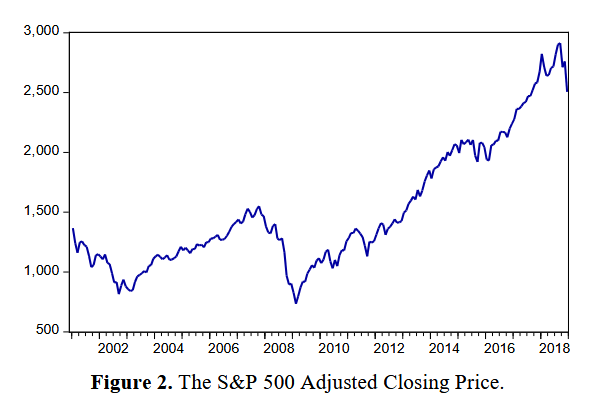

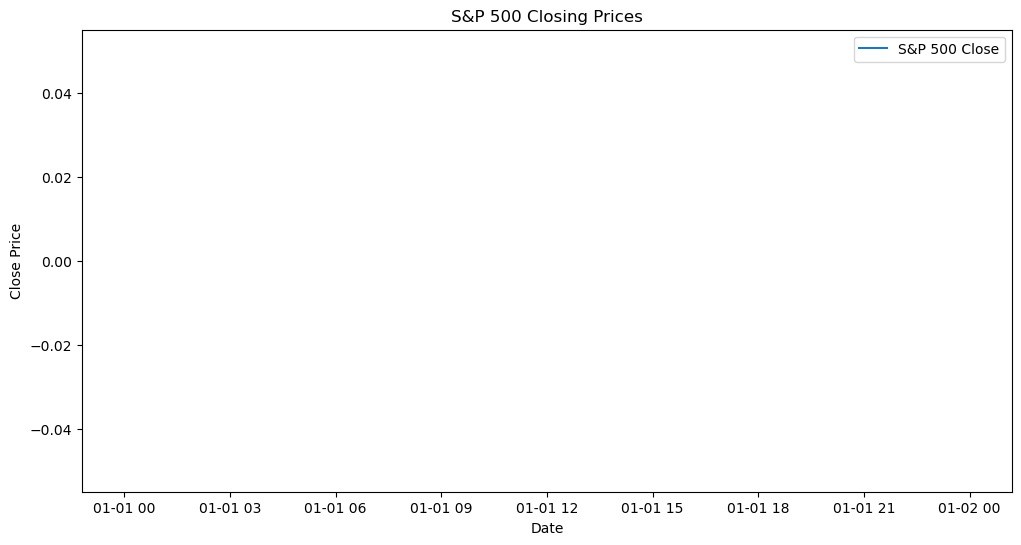

In [24]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['Close'], label='S&P 500 Close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Closing Prices')
plt.legend()
plt.show()

In terms of graphs we see that they plotted the whole df - sp500; not split train and test

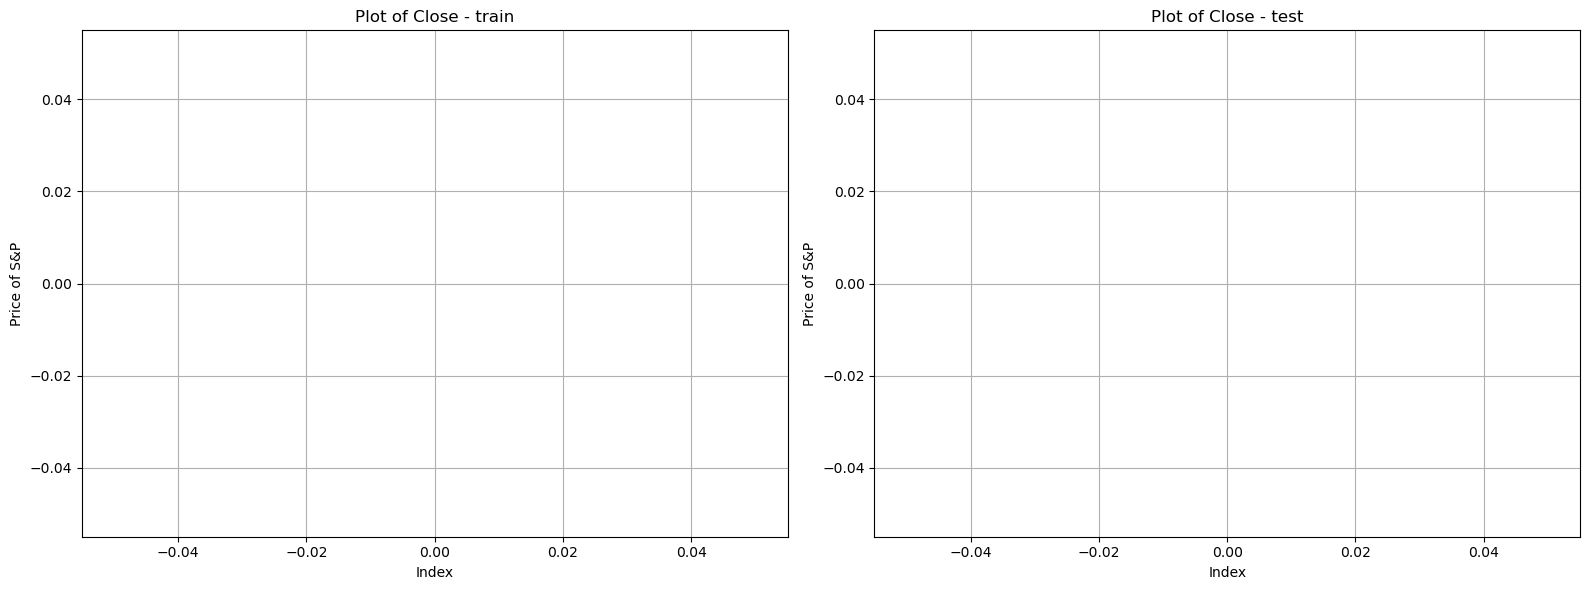

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train close prices on the left subplot
axs[0].plot(train['Close'], color='red')
axs[0].set_title('Plot of Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of S&P')
axs[0].grid(True)

# Plot test close prices on the right subplot
axs[1].plot(test['Close'], color='red')
axs[1].set_title('Plot of Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

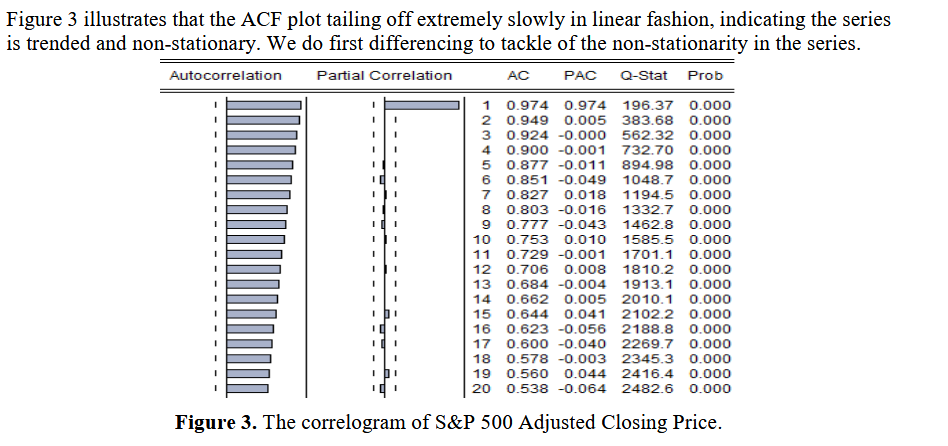

It is not defined they test ACF/PACF for the whole dataframa or only train; so we decided to test ACF/PACF/AC/PAC/Q-stat/Prob for full dataframe/train; no need for test since we have only 14 observations

In [1]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(sp500['Close'], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(sp500['Close'], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Calculate numerical ACF/PACF values
acf_values_sp500, acf_confint_sp500 = acf(sp500['Close'], nlags=20, alpha=0.05)
pacf_values_sp500, pacf_confint_sp500 = pacf(sp500['Close'], nlags=20, alpha=0.05)

# Ljung-Box Q-test
q_test_sp500 = acorr_ljungbox(sp500['Close'], lags=20, return_df=True) 

# Create EViews-style summary table
results_sp500 = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_sp500[1:],  # Exclude lag-0
    'PAC': pacf_values_sp500[1:],
    'Q-Stat': q_test_sp500['lb_stat'].values,
    'Prob': q_test_sp500['lb_pvalue'].values
})

print("\nAutocorrelation Summary:")
print(results_sp500.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9854  0.9900   212.6577   0.0
1     2  0.9654 -0.2809   417.7318   0.0
2     3  0.9458  0.0852   615.4782   0.0
3     4  0.9225 -0.2491   804.5125   0.0
4     5  0.8989  0.1037   984.8270   0.0
5     6  0.8763 -0.0254  1157.0137   0.0
6     7  0.8553  0.1209  1321.8419   0.0
7     8  0.8339 -0.1322  1479.2653   0.0
8     9  0.8112 -0.0286  1628.9594   0.0
9    10  0.7891 -0.0154  1771.2767   0.0
10   11  0.7656 -0.0869  1905.9074   0.0
11   12  0.7399 -0.0651  2032.2869   0.0
12   13  0.7163  0.1432  2151.3079   0.0
13   14  0.6933 -0.0806  2263.3541   0.0
14   15  0.6720  0.1797  2369.1463   0.0
15   16  0.6513 -0.1834  2469.0088   0.0
16   17  0.6303  0.0769  2563.0180   0.0
17   18  0.6099 -0.1323  2651.4687   0.0
18   19  0.5902  0.1928  2734.7328   0.0
19   20  0.5692 -0.2900  2812.5642   0.0


So we see that values from the paper and here are not aligned, so we need to test train/test

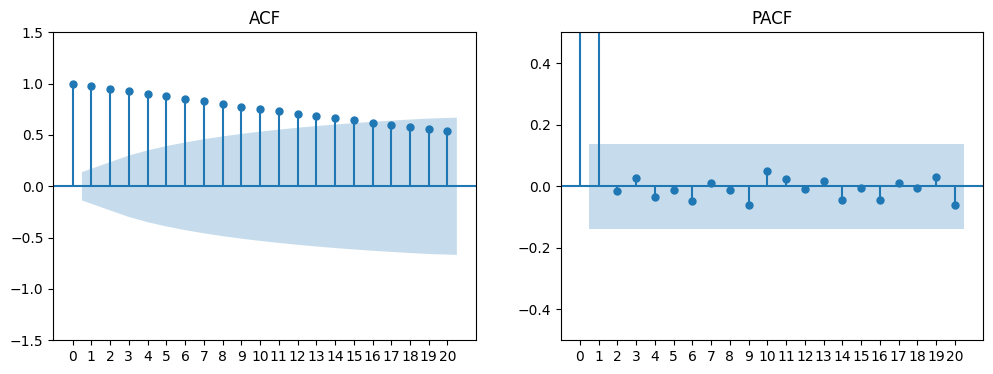

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(train['Close'], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-1.5,1.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(train['Close'], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [ ]:
# Calculate numerical ACF/PACF values
acf_values_train, acf_confint_train = acf(train['Close'], nlags=20, alpha=0.05)
pacf_values_train, pacf_confint_train = pacf(train['Close'], nlags=20, alpha=0.05)

# Ljung-Box Q-test
q_test_train = acorr_ljungbox(train['Close'], lags=20, return_df=True) 

# Create EViews-style summary table
results_train = pd.DataFrame({
    'Lag': range(1, 21),
    'AC': acf_values_train[1:],  # Exclude lag-0
    'PAC': pacf_values_train[1:],
    'Q-Stat': q_test_train['lb_stat'].values,
    'Prob': q_test_train['lb_pvalue'].values
})

print("\nAutocorrelation Summary:")
print(results_train.round(4))


Autocorrelation Summary:
    Lag      AC     PAC     Q-Stat  Prob
0     1  0.9749  0.9797   194.8331   0.0
1     2  0.9496 -0.0188   380.6137   0.0
2     3  0.9263  0.0346   558.2774   0.0
3     4  0.9019 -0.0425   727.5654   0.0
4     5  0.8775 -0.0148   888.6153   0.0
5     6  0.8514 -0.0600  1041.0184   0.0
6     7  0.8265  0.0144  1185.3841   0.0
7     8  0.8019 -0.0157  1321.9685   0.0
8     9  0.7747 -0.0771  1450.1231   0.0
9    10  0.7508  0.0665  1571.1219   0.0
10   11  0.7290  0.0316  1685.7818   0.0
11   12  0.7070 -0.0114  1794.2029   0.0
12   13  0.6864  0.0218  1896.9420   0.0
13   14  0.6642 -0.0577  1993.6548   0.0
14   15  0.6426 -0.0094  2084.6432   0.0
15   16  0.6196 -0.0595  2169.6994   0.0
16   17  0.5976  0.0186  2249.2446   0.0
17   18  0.5766 -0.0084  2323.6929   0.0
18   19  0.5574  0.0442  2393.6446   0.0
19   20  0.5357 -0.0828  2458.6099   0.0


Here we see that results are similar, but there is still some rounding or precision 

In [ ]:
sp500

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
211,2018-08-01,2901.520020,2916.500000,2796.340088,2821.169922,69523070000,85.229980
212,2018-09-01,2913.979980,2940.909912,2864.120117,2896.959961,63031510000,12.459961
213,2018-10-01,2711.739990,2939.860107,2603.540039,2926.290039,91930980000,-202.239990
214,2018-11-01,2760.169922,2815.149902,2631.090088,2717.580078,80620020000,48.429932


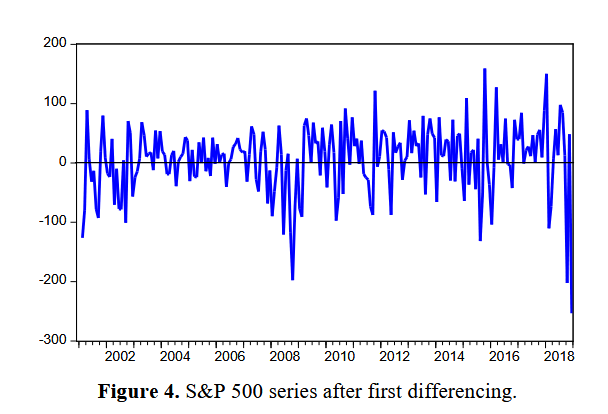

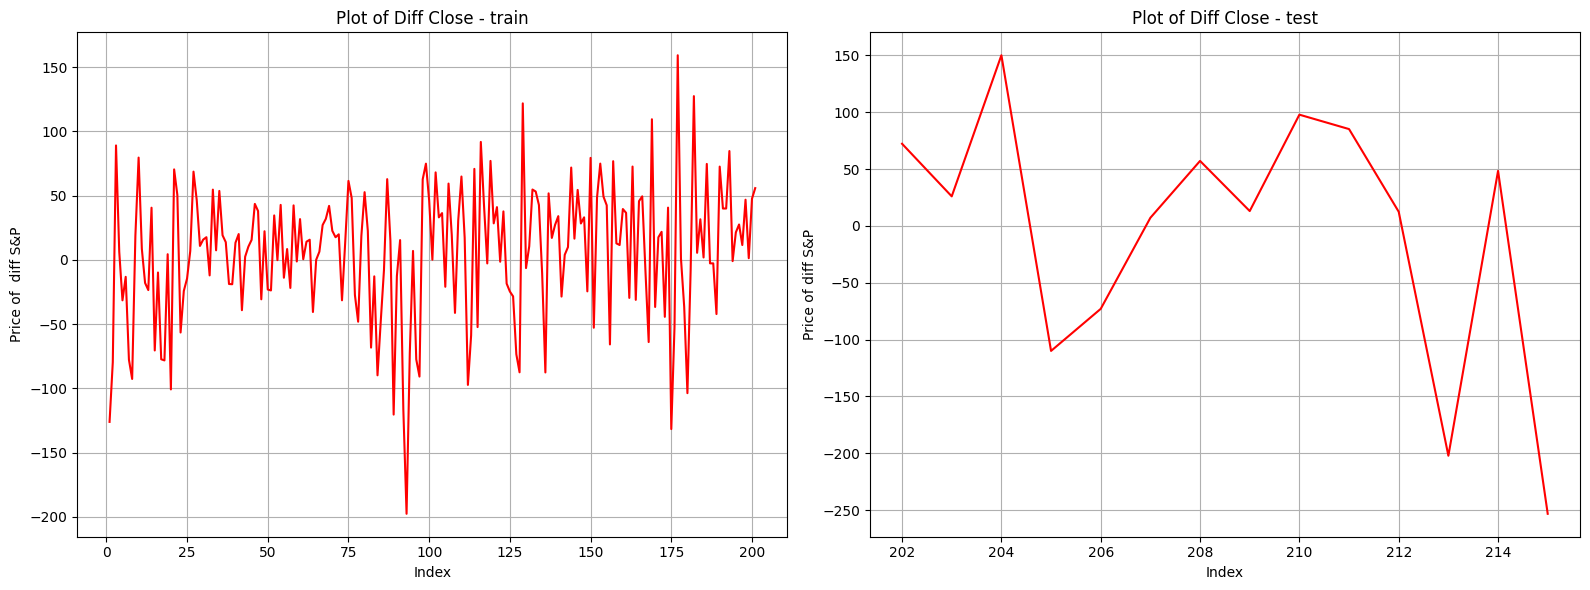

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train difference of close prices on the left subplot
axs[0].plot(train['close_diff'], color='red')
axs[0].set_title('Plot of Diff Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of  diff S&P')
axs[0].grid(True)

# Plot test difference of close prices on the right subplot
axs[1].plot(test['close_diff'], color='red')
axs[1].set_title('Plot of Diff Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of diff S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

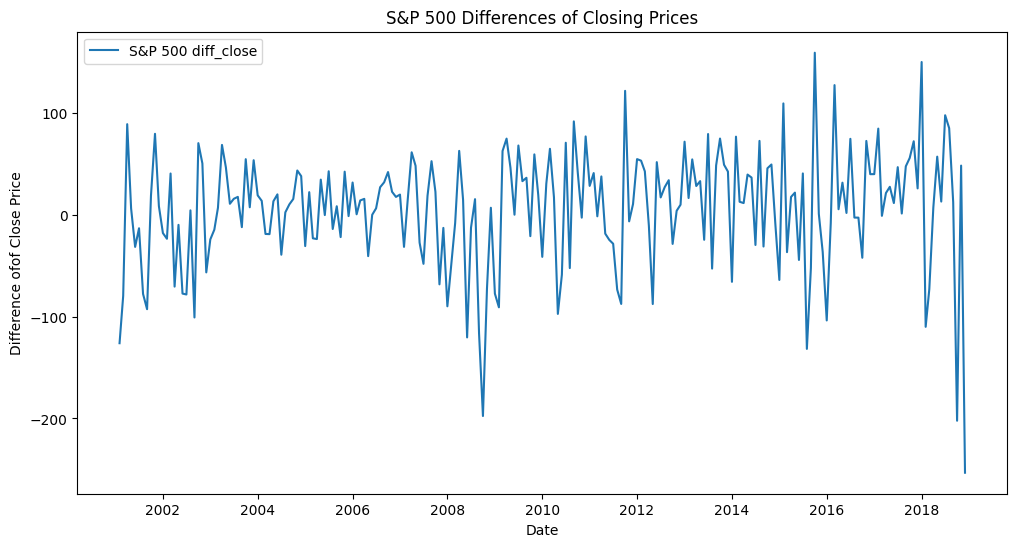

In [ ]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500['Date'], sp500['close_diff'], label='S&P 500 diff_close')  # Plot Date vs Close
plt.xlabel('Date')
plt.ylabel('Difference ofof Close Price')
plt.title('S&P 500 Differences of Closing Prices')
plt.legend()
plt.show()

In [ ]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


In [ ]:
def adf_test(series, title=''):
    """Perform ADF test with trend and intercept"""
    result = adfuller(series, regression='ct', autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }
    return output


In [ ]:

# Run tests
level = adf_test(sp500['Close'], "Level")
diff = adf_test(pd.Series(sp500['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -2.16731      0.50826
Trend and intercept First difference       -13.25297      0.00000

Critical Values:
1%%: -4.00151
5%%: -3.43111
10%%: -3.13916


In [ ]:
# Run tests
level = adf_test(train['Close'], "Level")
diff = adf_test(pd.Series(train['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -1.42949      0.85205
Trend and intercept First difference       -13.20496      0.00000

Critical Values:
1%%: -4.00453
5%%: -3.43256
10%%: -3.14001


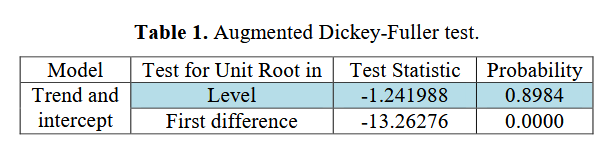

Possible challenge: such small difference from the work can be from the problem that it is not stated when differences where calculated, since in our approach we calculated them

In [ ]:
train

,Date,Close,High,Low,Open,Volume,close_diff
0,2001-01-01,1366.010010,1383.369995,1274.619995,1320.280029,27829800000,NaN
1,2001-02-01,1239.939941,1376.380005,1215.439941,1366.010010,21644400000,-126.070068
2,2001-03-01,1160.329956,1267.420044,1081.189941,1239.939941,27806610000,-79.609985
3,2001-04-01,1249.459961,1269.300049,1091.989990,1160.329956,25409990000,89.130005
4,2001-05-01,1255.819946,1315.930054,1232.000000,1249.459961,24525900000,6.359985
...,...,...,...,...,...,...,...
197,2017-06-01,2423.409912,2453.820068,2405.699951,2415.649902,81078810000,11.609863
198,2017-07-01,2470.300049,2484.040039,2407.699951,2431.389893,63348090000,46.890137
199,2017-08-01,2471.649902,2490.870117,2417.350098,2477.100098,70784900000,1.349854
200,2017-09-01,2519.360107,2519.439941,2446.550049,2474.419922,66624120000,47.710205


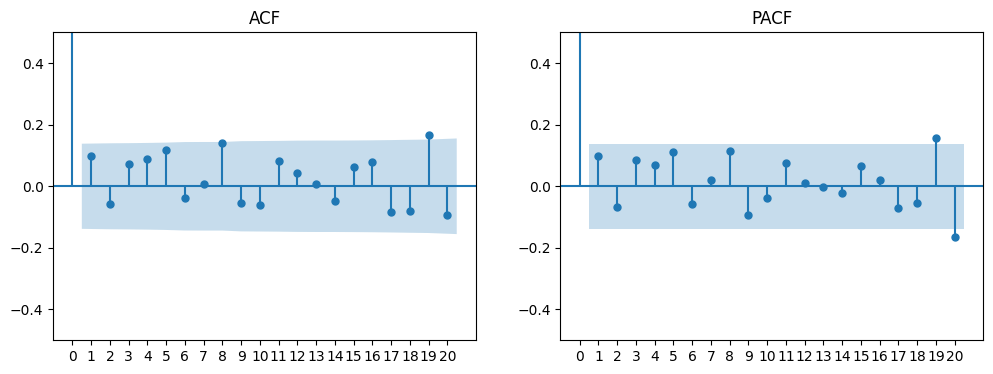

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(train['Close'].diff()[1:]), lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(np.array(train['Close'].diff()[1:]), lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In their paper they didn't provide any ACF/PACF for stationary series; also they mixed up with figure numbering

So it is not clear why they decided to stick with ARIMA212 since these lags are not significant and we decided to test for different lags including 8/19; we need to consider ARMA with lags 8 or 19, but it doesn't make sense since we have our test out-of-sample datafram which consists of only 14 month

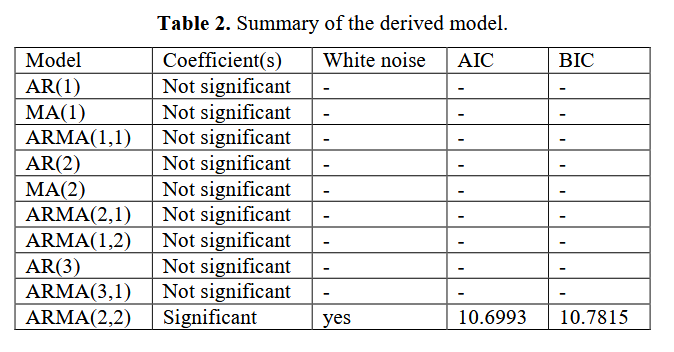

In [ ]:
ar1 = ARIMA(train['Close'].values, order=(1, 1, 0)).fit()
ma1 = ARIMA(train['Close'].values, order=(0, 1, 1)).fit()
arma11 = ARIMA(train['Close'].values, order=(1, 1, 1)).fit()
ar2 = ARIMA(train['Close'].values, order=(2, 1, 0)).fit()
ma2 = ARIMA(train['Close'].values, order=(0, 1, 2)).fit()
arma21 = ARIMA(train['Close'].values, order=(2, 1, 1)).fit()
arma12 = ARIMA(train['Close'].values, order=(1, 1, 2)).fit()
ar3 = ARIMA(train['Close'].values, order=(3, 1, 0)).fit()
arma31 = ARIMA(train['Close'].values, order=(3, 1, 1)).fit()
arma22 = ARIMA(train['Close'].values, order=(2, 1, 2)).fit()
ar8= ARIMA(train['Close'].values, order=([8], 1, 0)).fit()
ma8= ARIMA(train['Close'].values, order=(0, 1, [8])).fit()
arma88 = ARIMA(train['Close'].values, order=([8], 1, [8])).fit()
ar19= ARIMA(train['Close'].values, order=([19], 1, 0)).fit()
ma19= ARIMA(train['Close'].values, order=(0, 1, [19])).fit()
ar20= ARIMA(train['Close'].values, order=([20], 1, 0)).fit()
ma20= ARIMA(train['Close'].values, order=(0, 1, [20])).fit()


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
models = [ar1, ma1, arma11, ar2, ma2, arma21, arma12, ar3, arma31, arma22, ar8, ma8, arma88, ar19, ma19, ar20, ma20] # list with all the models
names = ['ar1', 'ma1', 'arma11','ar2', 'ma2', 'arma21', 'arma12', 'ar3', 'arma31', 'arma22', 'ar8', 'ma8', 'arma88', 'ar19', 'ma19', 'ar20', 'ma20'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
      model      AIC      BIC
13    ar19  2161.45  2168.06
14    ma19  2161.96  2168.57
10     ar8  2163.55  2170.15
12  arma88  2164.11  2174.02
9   arma22  2164.14  2180.65
11     ma8  2164.24  2170.85
1      ma1  2165.87  2172.47
0      ar1  2166.21  2172.81
2   arma11  2166.57  2176.48
8   arma31  2166.58  2183.10
15    ar20  2167.17  2173.78
4      ma2  2167.19  2177.10
16    ma20  2167.37  2173.97
3      ar2  2167.58  2177.49
7      ar3  2167.68  2180.89
6   arma12  2168.57  2181.79
5   arma21  2168.57  2181.79
Models by BIC:
      model      AIC      BIC
13    ar19  2161.45  2168.06
14    ma19  2161.96  2168.57
10     ar8  2163.55  2170.15
11     ma8  2164.24  2170.85
1      ma1  2165.87  2172.47
0      ar1  2166.21  2172.81
15    ar20  2167.17  2173.78
16    ma20  2167.37  2173.97
12  arma88  2164.11  2174.02
2   arma11  2166.57  2176.48
4      ma2  2167.19  2177.10
3      ar2  2167.58  2177.49
9   arma22  2164.14  2180.65
7      ar3  2167.68  2180.89
6   arma12 

In [ ]:
print(ar19.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:              ARIMA([19], 1, 0)   Log Likelihood               -1078.726
Date:                Thu, 15 May 2025   AIC                           2161.453
Time:                        18:53:19   BIC                           2168.059
Sample:                             0   HQIC                          2164.126
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L19         0.1975      0.074      2.654      0.008       0.052       0.343
sigma2      2675.7055    230.431     11.612      0.000    2224.068    3127.343
Ljung-Box (L1) (Q):                   3.85   Jarque-

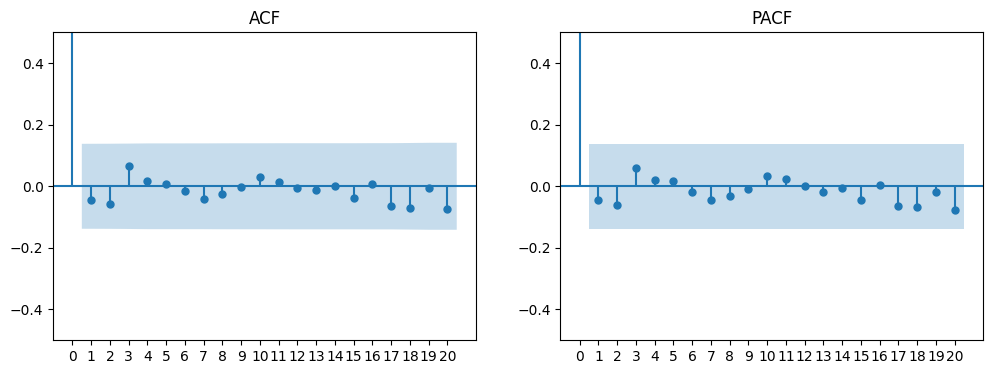

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(ar19.resid, lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(ar19.resid, lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

In [ ]:
print(ar8.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:               ARIMA([8], 1, 0)   Log Likelihood               -1079.773
Date:                Thu, 15 May 2025   AIC                           2163.546
Time:                        18:55:01   BIC                           2170.153
Sample:                             0   HQIC                          2166.220
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L8          0.1639      0.073      2.259      0.024       0.022       0.306
sigma2      2710.3980    251.710     10.768      0.000    2217.055    3203.741
Ljung-Box (L1) (Q):                   2.44   Jarque-

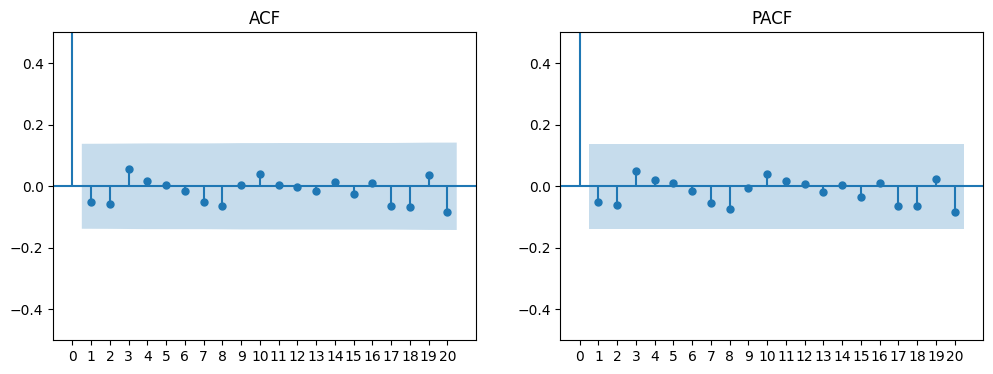

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(ar8.resid, lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(ar8.resid, lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

So it is not clear why they decided to stick with ARIMA212 since these lags are not significant and we decided to test for different lags including 8/19; we need to consider ARMA with lags 8 or 19, but it doesn't make sense since we have our test out-of-sample datafram which consists of only 14 month

In [ ]:
# Assuming sp500 is sorted by date in ascending order
train_size = int(len(sp500) * 0.8)

train_df = sp500.iloc[:train_size]
test_df = sp500.iloc[train_size:]

In [ ]:
train_df.shape

(172, 7)

In [ ]:
test_df.shape

(44, 7)

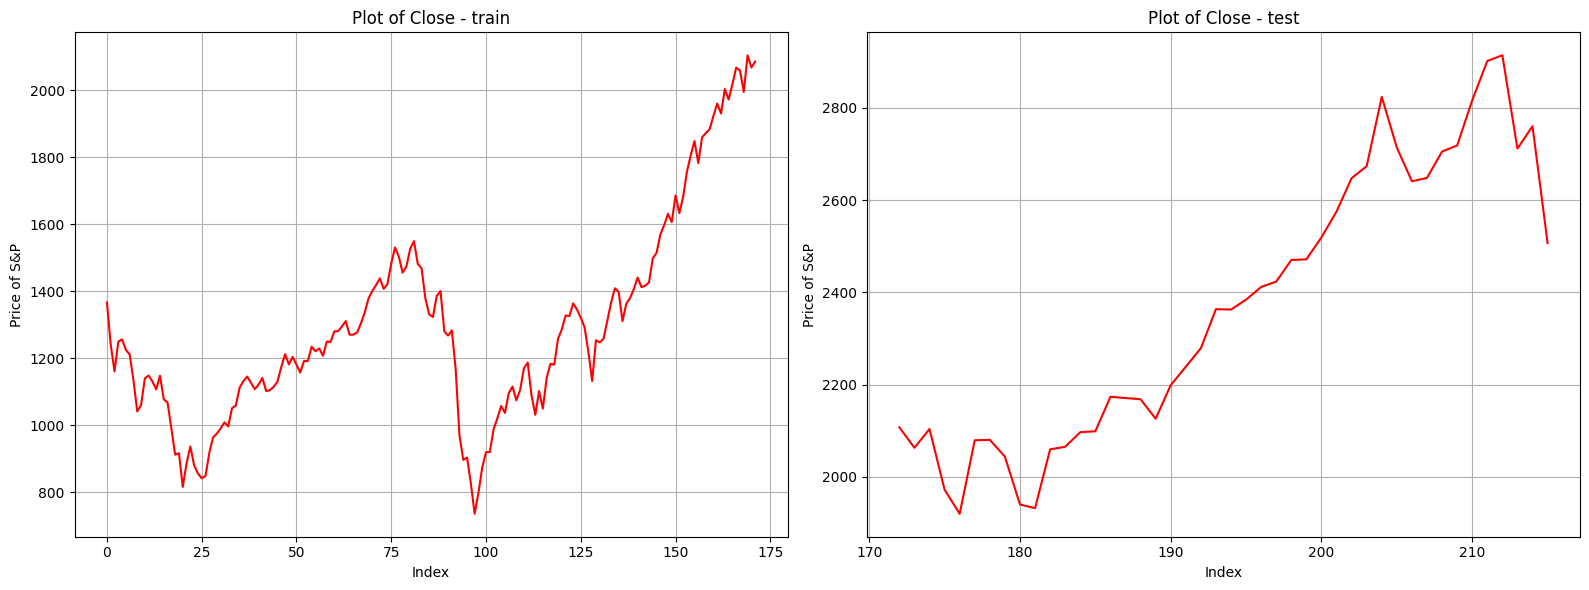

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot train difference of close prices on the left subplot
axs[0].plot(train_df['Close'], color='red')
axs[0].set_title('Plot of Close - train')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Price of S&P')
axs[0].grid(True)

# Plot test difference of close prices on the right subplot
axs[1].plot(test_df['Close'], color='red')
axs[1].set_title('Plot of Close - test')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Price of S&P')
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [ ]:
# Run tests
level = adf_test(train_df['Close'], "Level")
diff = adf_test(pd.Series(train_df['close_diff']).dropna(), "First Difference")

# Create results table
results = pd.DataFrame({
    'Model': ['Trend and intercept', 'Trend and intercept'],
    'Data': ['Level', 'First difference'],
    'Test Statistic': [level['Test Statistic'], diff['Test Statistic']],
    'Probability': [level['p-value'], diff['p-value']]
})

# Format output
print("Table 1. Augmented Dickey-Fuller Test\n")
print(results.to_string(float_format=lambda x: f"{x:.5f}", index=False))

# Add critical values
print("\nCritical Values:")
for key in level['Critical Values']:
    print(f"{key}%: {level['Critical Values'][key]:.5f}")

Table 1. Augmented Dickey-Fuller Test

              Model             Data  Test Statistic  Probability
Trend and intercept            Level        -1.41746      0.85571
Trend and intercept First difference       -11.90306      0.00000

Critical Values:
1%%: -4.01271
5%%: -3.43648
10%%: -3.14231


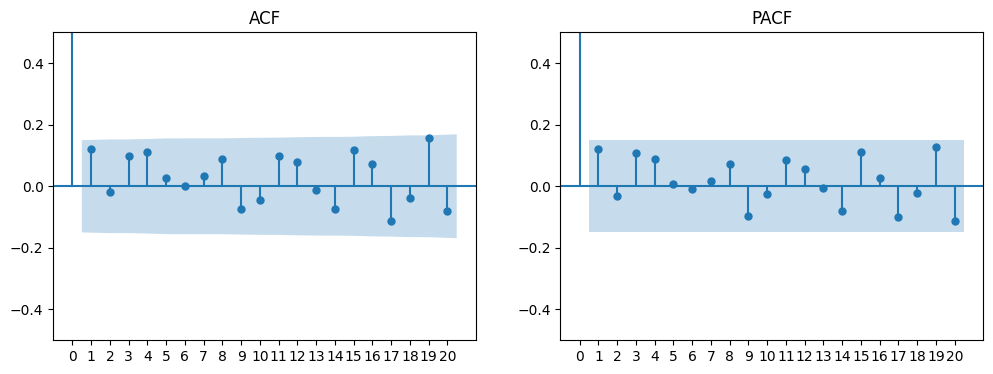

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(train_df['Close'].diff()[1:]), lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.5,0.5])
axes[0].set_xticks(range(0, 21, 1))

# Partial autocorrelation plot
plot_pacf(np.array(train_df['Close'].diff()[1:]), lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.5,0.5])
axes[1].set_xticks(range(0, 21, 1))

plt.show()

We see that it is montlhly data is probably white noise; no significant autocorrelation; so maybe ARIMA is not the best approach for such type of data; since SP500 monthly data is too wide

In [ ]:
arma00 = ARIMA(train_df['Close'].values, order=(0, 1, 0)).fit()
ar1 = ARIMA(train_df['Close'].values, order=(1, 1, 0)).fit()
ma1 = ARIMA(train_df['Close'].values, order=(0, 1, 1)).fit()
arma11 = ARIMA(train_df['Close'].values, order=(1, 1, 1)).fit()
ar2 = ARIMA(train_df['Close'].values, order=(2, 1, 0)).fit()
ma2 = ARIMA(train_df['Close'].values, order=(0, 1, 2)).fit()
arma21 = ARIMA(train_df['Close'].values, order=(2, 1, 1)).fit()
arma12 = ARIMA(train_df['Close'].values, order=(1, 1, 2)).fit()
arma22 = ARIMA(train_df['Close'].values, order=(2, 1, 2)).fit()


C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
models = [arma00, ar1, ma1, arma11, ar2, ma2, arma21, arma12, arma22] # list with all the models
names = ['arma00', 'ar1', 'ma1', 'arma11','ar2', 'ma2', 'arma21', 'arma12', 'arma22'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
     model      AIC      BIC
2     ma1  1832.43  1838.72
1     ar1  1832.61  1838.89
0  arma00  1833.45  1836.60
3  arma11  1834.17  1843.60
5     ma2  1834.30  1843.73
4     ar2  1834.51  1843.93
7  arma12  1834.91  1847.48
8  arma22  1836.13  1851.84
6  arma21  1836.17  1848.73
Models by BIC:
     model      AIC      BIC
0  arma00  1833.45  1836.60
2     ma1  1832.43  1838.72
1     ar1  1832.61  1838.89
3  arma11  1834.17  1843.60
5     ma2  1834.30  1843.73
4     ar2  1834.51  1843.93
7  arma12  1834.91  1847.48
6  arma21  1836.17  1848.73
8  arma22  1836.13  1851.84


ARIMA is not capturing all effects and is probably not the most appropriate model for such frequency of data

In [ ]:
print(ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  172
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -914.217
Date:                Thu, 15 May 2025   AIC                           1832.435
Time:                        19:24:42   BIC                           1838.718
Sample:                             0   HQIC                          1834.984
                                - 172                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1396      0.066      2.108      0.035       0.010       0.269
sigma2      2576.9432    256.466     10.048      0.000    2074.279    3079.607
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [ ]:
returns = train['Close'].diff().dropna() 

In [ ]:
train_df.shape

(172, 7)

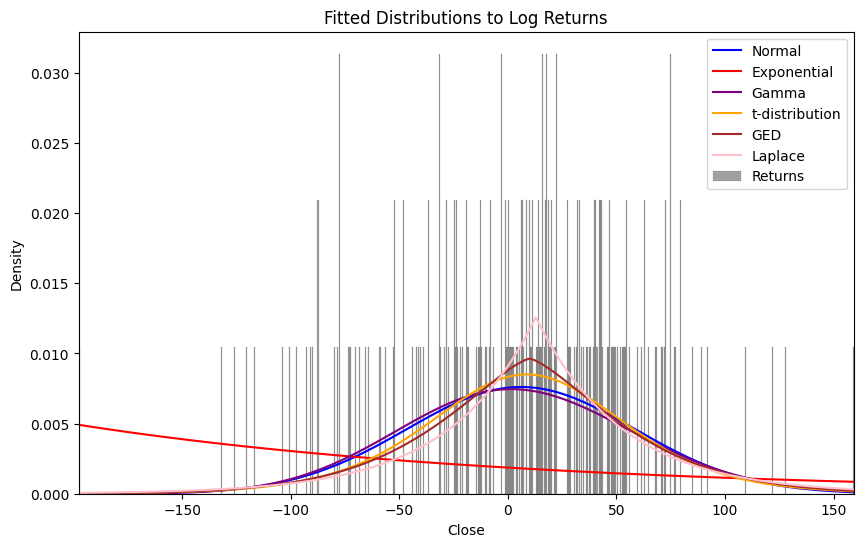

In [ ]:
params_normal = norm.fit(returns)
params_expon = expon.fit(returns)
params_gamma = gamma.fit(returns)
params_t = t.fit(returns)
params_ged = gennorm.fit(returns)
params_laplace = laplace.fit(returns)

lower_limit = returns.min()
upper_limit = returns.max()
x = np.linspace(lower_limit, upper_limit, 1000)

pdf_normal = norm.pdf(x, *params_normal)
pdf_expon = expon.pdf(x, *params_expon)
pdf_gamma = gamma.pdf(x, *params_gamma)
pdf_t = t.pdf(x, *params_t)
pdf_ged = gennorm.pdf(x, *params_ged)
pdf_laplace = laplace.pdf(x, *params_laplace)

plt.figure(figsize=(10, 6))
sns.histplot(returns, kde=False, bins=750, stat='density', color='gray', label='Returns')  # Changed to 200 bins
plt.plot(x, pdf_normal, label='Normal', color='blue')
plt.plot(x, pdf_expon, label='Exponential', color='red')
plt.plot(x, pdf_gamma, label='Gamma', color='purple')
plt.plot(x, pdf_t, label='t-distribution', color='orange')
plt.plot(x, pdf_ged, label='GED', color='brown')
plt.plot(x, pdf_laplace, label='Laplace', color='pink')
plt.xlim(lower_limit, upper_limit)
plt.title('Fitted Distributions to Log Returns')
plt.legend()
plt.show()



There is not enough obsservations to even fit GARCH model, so we need to find and attach few papers where it states that we need at least 250-300 observations to run GARCH but we have around 170